# FPGheArt - Week 5 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RBM as rbm
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Useful functions

In [2]:
def load(fname, spins= True):
    v = np.loadtxt(fname, delimiter=",", dtype = int)
    if spins:
        vmin = -1
        GAP = 2
        v = 2*v - 1
    else:
        vmin = 0
        GAP = 1
    return v.copy()

def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5
    return (x, y)

def mycolor(val):
    if val > 0:
        return 'red'
    elif val < 0:
        return 'blue'
    return 'black'

def plotgraph(w, a, b, epoch=0, M = 3, L = 8):
    A = 2./w.max()
    (x1, y1) = create_coord(L, 0)
    (x2, y2) = create_coord(M, 1)
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder = 1, lw=A*np.abs(w[i][j]))
    A = 300./(a.max() + b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s = A*np.abs(a[i]), zorder = 2, c = mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j], y2[j], s = A*np.abs(b[j]), zorder = 2, c = mycolor(b[j]))
    plt.title(f">0 red, <0 blue, epoch = {epoch}")
    plt.show()
    
def noise_score(seq):
    for n in range(N):
        for i in range(len(seq)):
            if (v0[n] == seq[i]).all():
                count += 1
                break

## Data load

We can start by loading the file cointaining the 4 different sequences 

In [3]:
q=0.1
fname = "DATA/dataRBM_seq4_q" + str(q) + ".csv"
v = load(fname)
#store initial values
v0 = v.copy()

For some analysis we will need the sequences themselves in order to estimate the result quality

In [4]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]

## RBM application

We can start using the RBM built during lesson, having three hidden nodes, 50 epochs, learning rate of 1 and a minibatch of 500 samples. This from now will be our default model. 

In [5]:
my_rbm = rbm.RBM(random_state = 123)
my_rbm.fit(v)

We can use the plot function in order to visualize the weights 

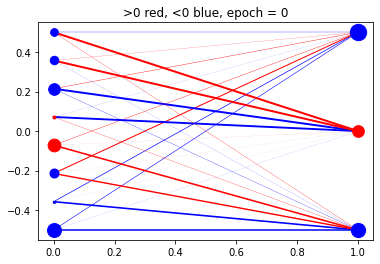

In [6]:
plotgraph(*(my_rbm.params()))

As expected knowing how input data are generated, it seems that only two nodes are relevant for the computation; for the sake of simplicity the model we can use only two hidden nodes.

In [10]:
my_rbm = rbm.RBM(M=2, random_state = 12)
my_rbm.fit(v)

From the following plot we can see the same weight structure and the same pattern recognition that highlights the different input couples.

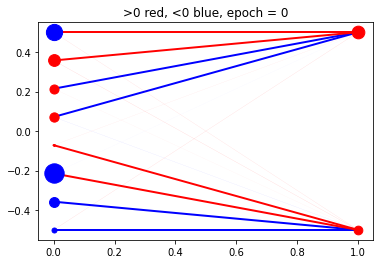

In [11]:
plotgraph(*(my_rbm.params()), M=2)

In order to measure the performance of the RBM we can use a score function. This function returns the fraction of samples that match one of the original sequences. After the training with $\beta = 1$, we use different values to generate back the fantasy data in negative phase. 

In [110]:
betas = list(np.arange(1,10,0.1))

In [24]:
scores_b = []
for beta in betas:
    scores_b.append(my_rbm.score(v,seq, beta = beta))

We can also try changing $\beta$ in the positive phase.

In [25]:
scores_bh = []
for beta in betas:
    scores_bh.append(my_rbm.score(v,seq, beta = beta, beta_h = beta))

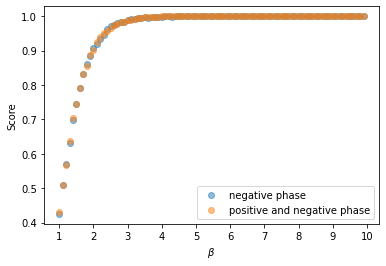

In [31]:
plt.scatter(betas, scores_b, marker = 'o', label = 'Negative phase', alpha = 0.5)
plt.scatter(betas, scores_bh, marker = 'o', label = 'Positive and negative phase', alpha = 0.5)
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Score')
plt.legend()
plt.show()

From the plot we can see that, using $\beta > 3$ all the samples are brought back to one of the original sequences - even if not necessarily their original one. Using the $\beta$ parameter also in positive phase does not change the performaces.

In order to _compare_ the fantasy data to the corresponding original sequences (without any noise), we define a "compare" function that counts the number of correctly denoised samples. The argument of the function are the original "clean" data, the noised ones and the $\beta$ parameters. From now on we use the $\beta$ parameter only in the negative phase

In [9]:
q=0.1
fname = "DATA/dataRBM_clean4_q" + str(q) + ".csv"
v_c = load(fname)

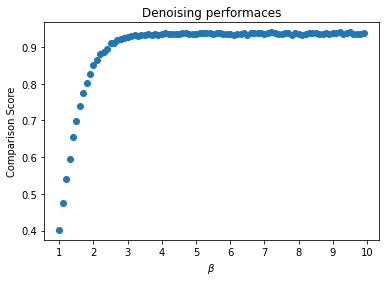

In [35]:
scores_comp = []
for beta in betas:
    scores_comp.append(my_rbm.compare(v0,v_c, beta = beta))

plt.scatter(betas, scores_comp)
plt.title('Denoising performaces')
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Comparison Score')
plt.show()

The RBM with two nodes has good performances in denoising, as expected for $\beta$ higher than 3. The comparison score has a similar $\beta$ dependance to the previous one, as expected. We may also notice that in the previous case the data were perfectly denoised in one of the 4 original sequences, in this case instead the performances tops at $\sim 0.9$ as some of them are not linked to the original one.

## Analysis on different number of hidden layers

We want to compare how the performances change using different numbers of hidden nodes.

In [6]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v))

As the effective performances change with differet betas we choose to use three values for each different M. 
Moreover we will provide a graph for both the compare and score function.

In [11]:
M_score_b1 = []
M_score_b2 = []
M_score_b3 = []
for rb in rbms:
    M_score_b1.append(rb.score(v0,seq, beta = 6))
    M_score_b2.append(rb.score(v0,seq, beta = 30))
    M_score_b3.append(rb.score(v0,seq, beta = 100))

In [12]:
M_compare_b1 = []
M_compare_b2 = []
M_compare_b3 = []
for rb in rbms:
    M_compare_b1.append(rb.compare(v0,v_c, beta = 6))
    M_compare_b2.append(rb.compare(v0,v_c, beta = 30))
    M_compare_b3.append(rb.compare(v0,v_c, beta = 100))

Text(69.0, 0.5, '$\\beta$')

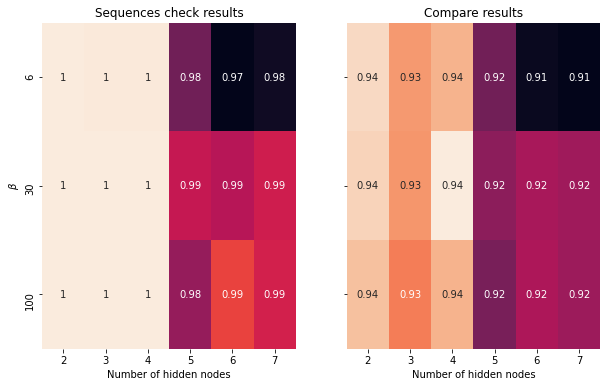

In [71]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b1,M_score_b2,M_score_b3]
matr_compare = [M_compare_b1,M_compare_b2,M_compare_b3]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[6,30,100] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[6,30,100], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results")
ax[0].set_ylabel(r"$\beta$")

As esplicited in the previous figure the different RMBs have really similar performances. In general we would say that a lower number of hidden nodes increases the performances. 

The following cell can be used to plot the coefficients for choosen configuration.

## Analysis on data generated from 5 sequences

We can now investigate how the RBM works on data containing 5 different sequences.

In [97]:
q=0.1
fname = "DATA/dataRBM_seq5_q" + str(q) + ".csv"
v_5 = load(fname)

seqstr = ['11001100', '00111100', '11000011', '00110011', '11111111']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
v0_5 = v_5.copy()

In [98]:
q=0.1
fname = "DATA/dataRBM_clean5_q" + str(q) + ".csv"
v5_c = load(fname)

y_5 = []
for n in range(len(v5_c)):
    for i in range(len(seq)):
        if (v5_c[n] == seq[i]).all():
                y_5.append(i)
                break

As before we will check the performances over different M selections.

In [99]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v_5))
    #plotgraph(*(my_rbm.params()), M=M)

In [100]:
M_score_b1 = []
M_score_b2 = []
M_score_b3 = []
M_score_b4 = []

for rb in rbms:
    M_score_b1.append(rb.score(v0_5,seq, beta = 1))
    M_score_b2.append(rb.score(v0_5,seq, beta = 5))
    M_score_b3.append(rb.score(v0_5,seq, beta = 9))
    M_score_b4.append(rb.score(v0_5,seq, beta = 15))

In [101]:
M_compare_b1 = []
M_compare_b2 = []
M_compare_b3 = []
M_compare_b4 = []

for rb in rbms:
    M_compare_b1.append(rb.compare(v0_5,v5_c, beta = 1))
    M_compare_b2.append(rb.compare(v0_5,v5_c, beta = 5))
    M_compare_b3.append(rb.compare(v0_5,v5_c, beta = 9))
    M_compare_b4.append(rb.compare(v0_5,v5_c, beta = 15))

Text(69.0, 0.5, '$\\beta$')

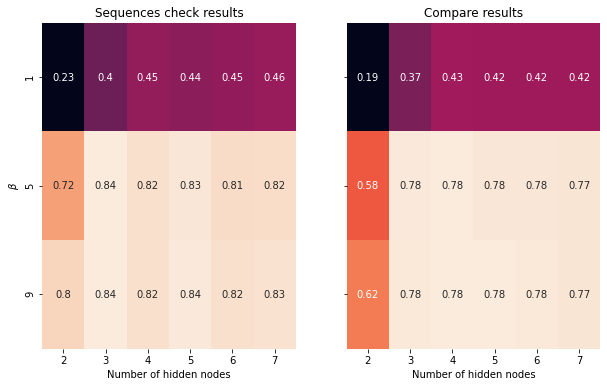

In [102]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b1,M_score_b2,M_score_b3, M_score_b4]
matr_compare = [M_compare_b1,M_compare_b2,M_compare_b3,M_compare_b4]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[1,5,9] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[1,5,9], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results")
ax[0].set_ylabel(r"$\beta$")

The best result is obtained with a number of hidden nodes higher than 3. We may notice that introducing a new sequence the performances drops for two nodes. We may also notice that using $\beta = 1$ the compare scores are lower with respect to the other values. Finally, the RBM in general have poorer performances than in former one. The fact that the check yields always 1 may be linked to some overfitting

In the following confusion matrices we will test 

<AxesSubplot:>

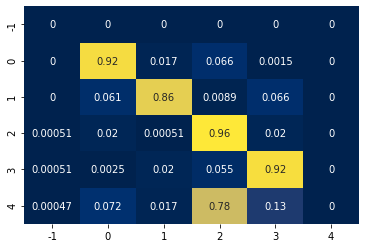

In [55]:
sns.heatmap(confusion_matrix(y_5, rbms[0].predict(v0_5,seq, beta = 60), normalize = "true"), annot=True, vmin = 0, vmax =1, cbar = False, yticklabels=list(range(-1,5)), xticklabels=list(range(-1,5)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

With 2 nodes one can see that the fourth label is never predicted and it gets confused most times with the second one. This network can recognize only the four classes previously seen, and by the way it does this job with the same accuracy it had before.

<AxesSubplot:>

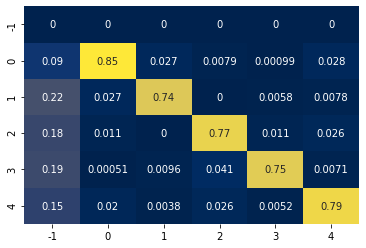

In [57]:
sns.heatmap(confusion_matrix(y_5, rbms[1].predict(v0_5,seq, beta = 60), normalize = "true"), annot=True, vmin = 0, vmax =1, cbar = False, yticklabels=list(range(-1,5)), xticklabels=list(range(-1,5)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.show()

By increasing the number of nodes the overral performances increase, since the RBM starts recognizing the fifth label. Nevertheless the specific performances on the first four classes shrinks, and all the misclassified samples are not associated to a label.

## Analysis on data generated from 6 sequences

In this section we will exploit the same procedure as before

In [58]:
q=0.1
fname = "DATA/dataRBM_seq6_q" + str(q) + ".csv"
v_6 = load(fname)

seqstr = ['11001100', '00111100', '11000011', '00110011', '11111111',  '10101000']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
v0_6 = v_6.copy()

In [86]:
q=0.1
fname = "DATA/dataRBM_clean6_q" + str(q) + ".csv"
v6_c = load(fname)

y_6 = []
for n in range(len(v5_c)):
    for i in range(len(seq)):
        if (v6_c[n] == seq[i]).all():
                y_6.append(i)
                break

In [60]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v_6))
    #plotgraph(*(my_rbm.params()), M=M)

In [61]:
M_score_b1 = []
M_score_b2 = []
M_score_b3 = []
for rb in rbms:
    M_score_b1.append(rb.score(v0_6,seq, beta = 6))
    M_score_b2.append(rb.score(v0_6,seq, beta = 30))
    M_score_b3.append(rb.score(v0_6,seq, beta = 100))

/home/filippo/Documents/POD/LOCPB/Week5/RBM.py:140: RuntimeWarning: overflow encountered in exp
  prob = 1./(1.+np.exp(-beta*DE*act))


In [62]:
M_compare_b1 = []
M_compare_b2 = []
M_compare_b3 = []
for rb in rbms:
    M_compare_b1.append(rb.compare(v0_6,v6_c, beta = 6))
    M_compare_b2.append(rb.compare(v0_6,v6_c, beta = 30))
    M_compare_b3.append(rb.compare(v0_6,v6_c, beta = 100))

Text(69.0, 0.5, '$\\beta$')

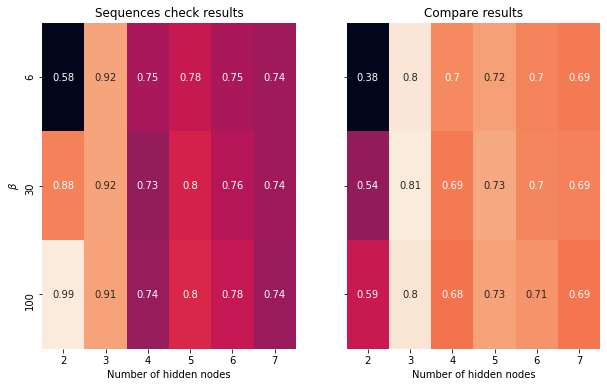

In [84]:
fig, ax = plt.subplots(1,2, figsize = (10,6), sharey = True)
matr_score = [M_score_b1,M_score_b2,M_score_b3]
matr_compare = [M_compare_b1,M_compare_b2,M_compare_b3]
sns.heatmap(matr_score, annot=True, cbar = False, ax = ax[0], yticklabels=[6,30,100] , xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
sns.heatmap(matr_compare, annot=True, cbar = False, ax = ax[1], yticklabels=[6,30,100], xticklabels=[2,3,4,5,6,7], vmin = 0, vmax =1)
ax[0].set_xlabel("Number of hidden nodes")
ax[1].set_xlabel("Number of hidden nodes")
ax[0].set_title("Sequences check results")
ax[1].set_title("Compare results")
ax[0].set_ylabel(r"$\beta$")

The best result is obtained with a number of hidden nodes higher than 3. We may notice that introducing a new sequence the performances drops for two nodes. Also, performances are worse for an higher number of hidden nodes.

<AxesSubplot:>

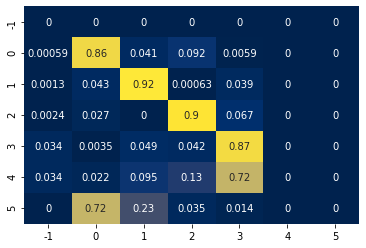

In [91]:
sns.heatmap(confusion_matrix(y_6,rbms[0].predict(v0_6,seq, beta = 100), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1, yticklabels=list(range(-1,6)), xticklabels=list(range(-1,6)), cmap = color)

As expected with two hidden nodes, the RBM is only capable to recognize the first 4 sequences.

<AxesSubplot:>

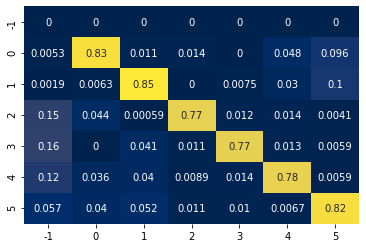

In [92]:
sns.heatmap(confusion_matrix(y_6, rbms[1].predict(v0_6,seq, beta = 100), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1, yticklabels=list(range(-1,6)), xticklabels=list(range(-1,6)), cmap = "cividis")

Best result is obtained with three hidden nodes, for which the scores are pretty much homogeneous.

<AxesSubplot:>

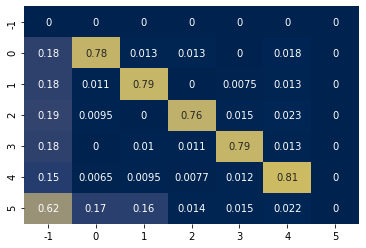

In [103]:
sns.heatmap(confusion_matrix(y_6, rbms[2].predict(v0_6,seq, beta = 100), normalize = "true"), annot=True, cbar = False, vmin = 0, vmax =1,  yticklabels=list(range(-1,6)), xticklabels=list(range(-1,6)), cmap = "cividis")

For a number of hidden layer higher than three, the network is more uncertain and many sequences are not correctly denoised

## Data generated with error rate q = 0.2

### Analysis on data generated from 4 sequences

In [56]:
q=0.2
fname = "DATA/dataRBM_seq4_q" + str(q) + ".csv"
v = load(fname)
v0 = v.copy()

In [57]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]

In [58]:
my_rbm = rbm.RBM(M=2, random_state = 12)
my_rbm.fit(v)

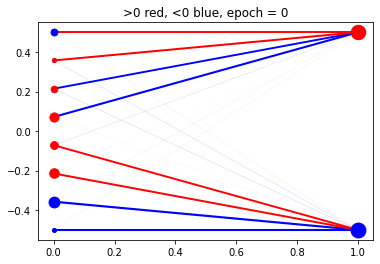

In [60]:
plotgraph(*(my_rbm.params()), M=2)

We can try different values for beta to see if the score has any improvement

In [61]:
betas = list(np.arange(1,20,0.1))

In [62]:
scores_b = []
for beta in betas:
    scores_b.append(my_rbm.score(v,seq, beta = beta))


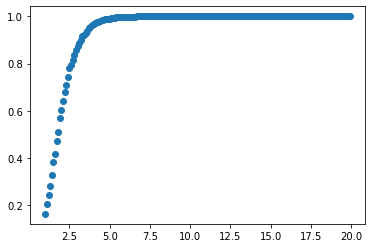

In [63]:
plt.scatter(betas, scores_b)

In [66]:
q=0.2
fname = "DATA/dataRBM_clean4_q" + str(q) + ".csv"
v_c = load(fname)

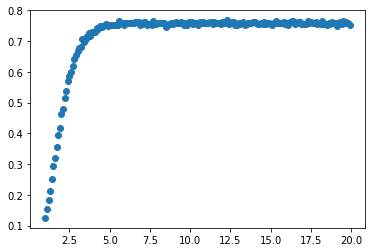

In [67]:
scores_comp = []
for beta in betas:
    scores_comp.append(my_rbm.compare(v0,v_c, beta = beta))

plt.scatter(betas, scores_comp)
plt.show()

### Analysis on data generated from 5 sequences

In [83]:
q=0.2
fname = "DATA/dataRBM_seq5_q" + str(q) + ".csv"
v_5 = load(fname)

seqstr = ['11001100', '00111100', '11000011', '00110011', '11111111']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
v0_5 = v_5.copy()

In [84]:
q=0.2
fname = "DATA/dataRBM_clean5_q" + str(q) + ".csv"
v5_c = load(fname)

In [85]:
my_rbm = rbm.RBM(M=5, random_state = 12)
my_rbm.fit(v_5)
my_rbm.score(v_5,seq)

0.1622

In [86]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v_5))
    #plotgraph(*(my_rbm.params()), M=M)

In [87]:
M_score_b6 = []
M_score_b15 = []
M_score_b30 = []
for rb in rbms:
    M_score_b6.append(rb.score(v_5,seq, beta = 6))
    M_score_b15.append(rb.score(v_5,seq, beta = 30))
    M_score_b30.append(rb.score(v_5,seq, beta = 100))

In [88]:
M_compare_b6 = []
M_compare_b15 = []
M_compare_b30 = []
for rb in rbms:
    M_compare_b6.append(rb.compare(v0_5,v5_c, beta = 6))
    M_compare_b15.append(rb.compare(v0_5,v5_c, beta = 30))
    M_compare_b30.append(rb.compare(v0_5,v5_c, beta = 100))

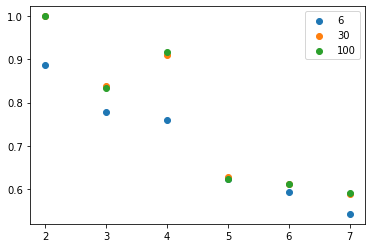

In [89]:
plt.scatter(Ml, M_score_b6, label = "6")
plt.scatter(Ml, M_score_b15, label = "30")
plt.scatter(Ml, M_score_b30, label = "100")
plt.legend()

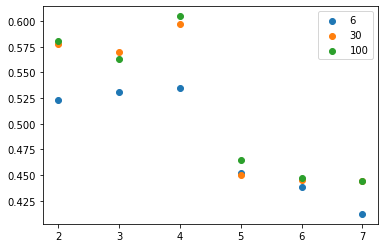

In [90]:
plt.scatter(Ml, M_compare_b6, label = "6")
plt.scatter(Ml, M_compare_b15, label = "30")
plt.scatter(Ml, M_compare_b30, label = "100")
plt.legend()

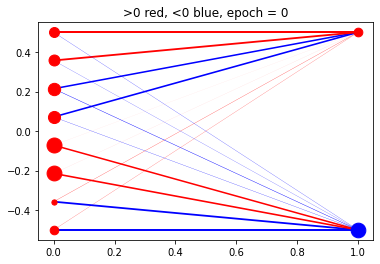

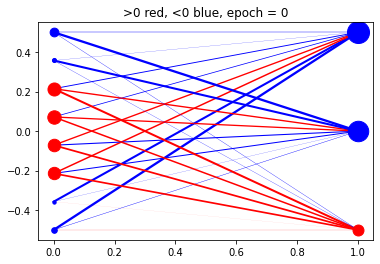

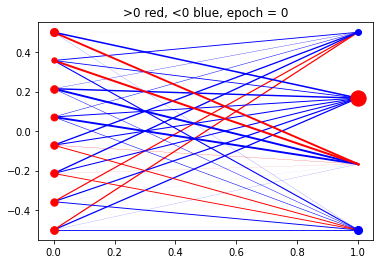

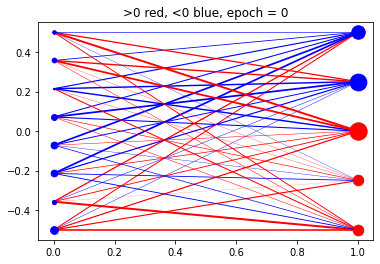

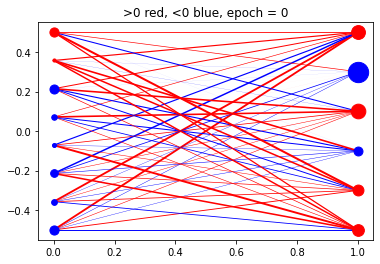

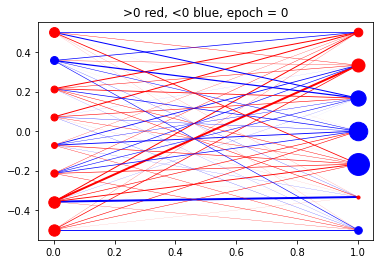

In [91]:
for rb, M in zip(rbms,Ml):
    plotgraph(*(rb.params()), M=M)

### Analysis on data generated from 6 sequences

In [70]:
q=0.2
fname = "DATA/dataRBM_seq6_q" + str(q) + ".csv"
v_6 = load(fname)

seqstr = ['11001100', '00111100', '11000011', '00110011', '11111111',  '10101000']
seq = [[int(i)*2-1 for i in seqstr[j]] for j in range(len(seqstr))]
v0_6 = v_6.copy()

In [71]:
q=0.2
fname = "DATA/dataRBM_clean6_q" + str(q) + ".csv"
v6_c = load(fname)


In [72]:
my_rbm = rbm.RBM(M=5, random_state = 12)
my_rbm.fit(v_6)
my_rbm.score(v_6,seq)

0.1574

In [73]:
Ml = [2,3,4,5,6,7]
rbms = []
for M in Ml:
    my_rbm = rbm.RBM(M=M, random_state = 12)
    rbms.append(my_rbm.fit(v_6))
    #plotgraph(*(my_rbm.params()), M=M)

In [74]:
M_score_b6 = []
M_score_b15 = []
M_score_b30 = []
for rb in rbms:
    M_score_b6.append(rb.score(v_6,seq, beta = 6))
    M_score_b15.append(rb.score(v_6,seq, beta = 30))
    M_score_b30.append(rb.score(v_6,seq, beta = 100))

In [75]:
M_compare_b6 = []
M_compare_b15 = []
M_compare_b30 = []
for rb in rbms:
    M_compare_b6.append(rb.compare(v0_6,v6_c, beta = 6))
    M_compare_b15.append(rb.compare(v0_6,v6_c, beta = 30))
    M_compare_b30.append(rb.compare(v0_6,v6_c, beta = 100))

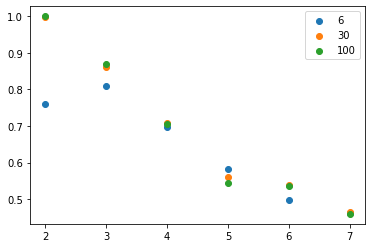

In [76]:
plt.scatter(Ml, M_score_b6, label = "6")
plt.scatter(Ml, M_score_b15, label = "30")
plt.scatter(Ml, M_score_b30, label = "100")
plt.legend()

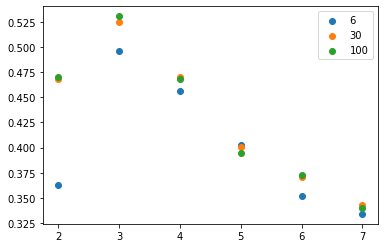

In [77]:
plt.scatter(Ml, M_compare_b6, label = "6")
plt.scatter(Ml, M_compare_b15, label = "30")
plt.scatter(Ml, M_compare_b30, label = "100")
plt.legend()

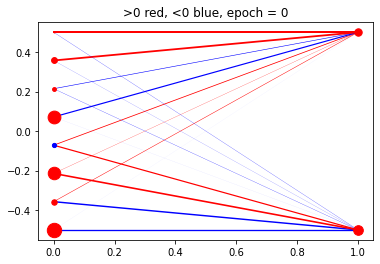

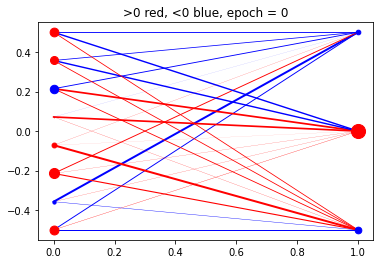

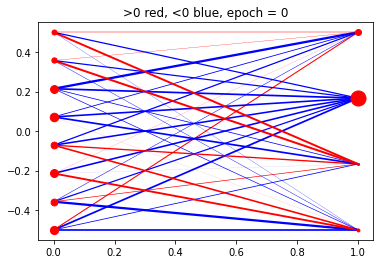

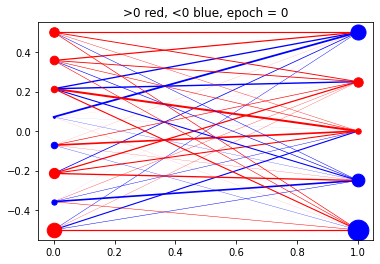

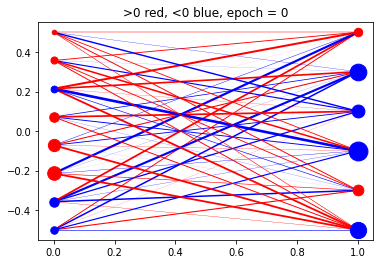

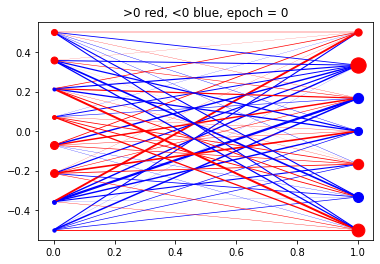

In [78]:
for rb, M in zip(rbms,Ml):
    plotgraph(*(rb.params()), M=M)

## Analysis with spins = False

In [113]:
q=0.1
fname = "DATA/dataRBM_seq4_q" + str(q) + ".csv"
v2 = load(fname, spins = False)
#store initial values
v20 = v2.copy()

In [126]:
q=0.1
fname = "DATA/dataRBM_clean4_q" + str(q) + ".csv"
v2_c = load(fname, spins = False)

y_2 = []
for n in range(len(v2_c)):
    for i in range(len(seq)):
        if (v2_c[n] == seq[i]).all():
                y_2.append(i)
                break

In [115]:
my_rbm2 = rbm.RBM(M=2, random_state = 123)
my_rbm2.fit(v2)

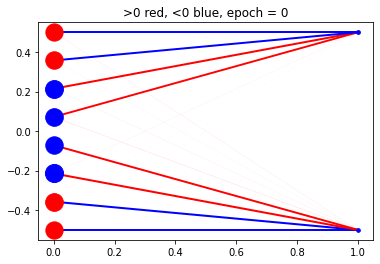

In [116]:
plotgraph(*(my_rbm2.params()), M=2)

In [154]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq2 = [[int(i) for i in seqstr[j]] for j in range(len(seqstr))]

No handles with labels found to put in legend.


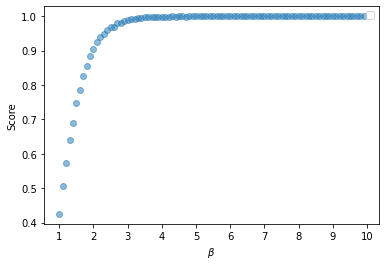

In [120]:
scores_b = []
for beta in betas:
    scores_b.append(my_rbm2.score(v2,seq, beta = beta))
    
plt.scatter(betas, scores_b, marker = 'o', alpha = 0.5)
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Score')
plt.show()

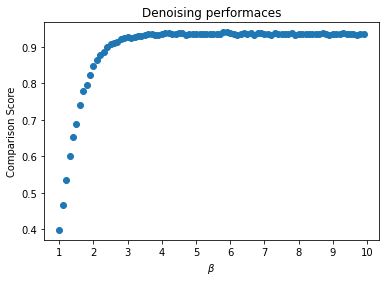

In [119]:
scores_comp = []
for beta in betas:
    scores_comp.append(my_rbm2.compare(v20,v2_c, beta = beta))

plt.scatter(betas, scores_comp)
plt.title('Denoising performaces')
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Comparison Score')
plt.show()

In [140]:
q=0.1
fname = "DATA/dataRBM_seq4_q" + str(q) + ".csv"
v = load(fname)
#store initial values
v0 = v.copy()

In [146]:
seqstr = ['11001100', '00111100', '11000011', '00110011']
seq = [[int(i)*2 - 1 for i in seqstr[j]] for j in range(len(seqstr))]

In [148]:
q=0.1
fname = "DATA/dataRBM_clean4_q" + str(q) + ".csv"
v_c = load(fname)

y = []
for n in range(len(v_c)):
    for i in range(len(seq)):
        if (v_c[n] == seq[i]).all():
                y.append(i)
                break

In [143]:
my_rbm = rbm.RBM(M=2)
my_rbm.fit(v)

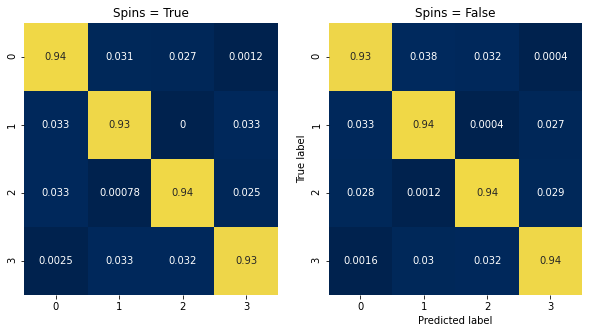

In [157]:
fig,ax = plt.subplots(1,2, figsize = (10,5))
sns.heatmap(confusion_matrix(y, my_rbm.predict(v0,seq, beta = 60), normalize = "true"), annot=True, ax =ax[0], vmin = 0, vmax =1, cbar = False, yticklabels=list(range(0,4)), xticklabels=list(range(0,4)), cmap = "cividis")
sns.heatmap(confusion_matrix(y_2, my_rbm2.predict(v20,seq2, beta = 60), normalize = "true"), annot=True,ax =ax[1], vmin = 0, vmax =1, cbar = False, yticklabels=list(range(0,4)), xticklabels=list(range(0,4)), cmap = "cividis")
plt.ylabel("True label")
plt.xlabel("Predicted label")
ax[0].set_title("Spins = True")
ax[1].set_title("Spins = False")

plt.show()

Using spins True or False, yields the same results in terms of accuracy.

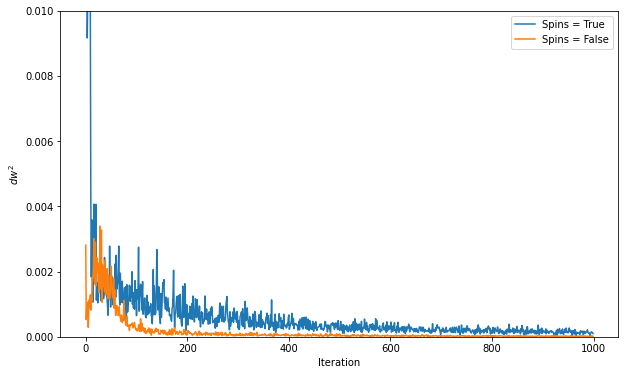

In [162]:
fig = plt.figure(figsize =(10,6))
plt.plot(range(1000),my_rbm.dw_history, label = "Spins = True")
plt.plot(range(1000),my_rbm2.dw_history, label = "Spins = False")
plt.ylim(0,0.01)
plt.xlabel("Iteration")
plt.ylabel(r"$dw^2$")
plt.legend()
plt.show()

From $dw^2$ trend, one can see that the configuration with Spins = False seems to converge faster, while the other seems to bounce more before reaching an effective convergence.

If we  now focus on the check and compare results  we can see that the using different spins has some remarkable effects on different curves

In [167]:
score2 = []
compare2 = []
for ep in range(2,50):
    my_rbm2 = rbm.RBM(M=2, nepochs = ep)
    my_rbm2.fit(v2)
    score2.append(my_rbm2.score(v2, seq2, beta = 100))
    compare2.append(my_rbm2.compare(v20,v2_c, beta = 100))

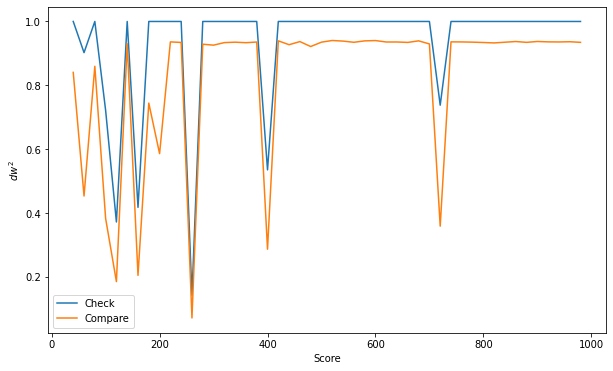

In [168]:
fig = plt.figure(figsize =(10,6))
plt.plot(np.arange(2,50)*20,score2, label = "Check")
plt.plot(np.arange(2,50)*20,compare, label = "Compare")
plt.xlabel("Score")
plt.ylabel(r"$dw^2$")
plt.legend()

In [169]:
score = []
compare = []
for ep in range(2,10):
    my_rbm = rbm.RBM(M=2, nepochs = ep)
    my_rbm.fit(v)
    score.append(my_rbm.score(v, seq, beta = 100))
    compare.append(my_rbm.compare(v0,v_c, beta = 100))

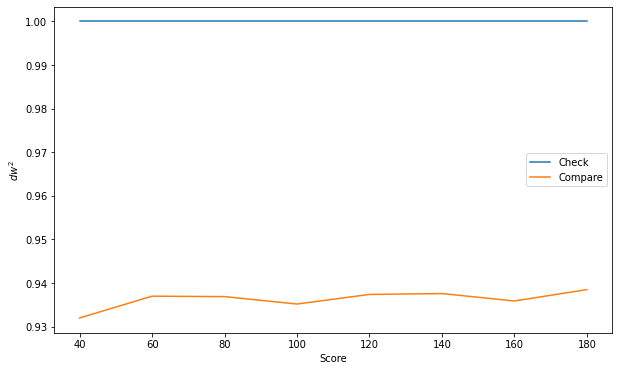

In [172]:
fig = plt.figure(figsize =(10,6))
plt.plot(np.arange(2,10)*20,score, label = "Check")
plt.plot(np.arange(2,10)*20,compare, label = "Compare")
plt.xlabel("Score")
plt.ylabel(r"$dw^2$")
plt.legend()